# STEP 1: SETUP

In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import ast
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler as SS
from sklearn.metrics.pairwise import cosine_similarity as cs
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_artist.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_genres.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/super_genres.json
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_w_genres.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_year.csv


# STEP 2: CREATE FUNCTIONS

In [2]:
def col(df, colname = "artists"):
    return np.array([int(x == colname) for x in df.columns]).argmax()
def query_artists(df, lists = [], full = False, strict = True):
    return pd.concat([query_artist(df, string = name, strict = strict) for name in lists], axis = 0)
def query_artist(df, string = "--", full = False, strict = True):
    lists = []
    if(not(strict)):
        string = "(.*?)"+string+"(.*?)"
    for i, artist in enumerate(df["artists"]):
        if(len(re.findall(string, "".join(artist))) != 0):
            if(full):
                lists.append(df.iloc[i])
            else:
                lists.append(df.iloc[i, [col(df, "artists"), col(df, "genres")]])           
    if(full): 
        return pd.DataFrame(lists, columns = df.columns)
    else:
        return pd.DataFrame(lists, columns = ["artists", "genres"])
def perfect_eval(string):
    try:
        return ast.literal_eval(string)
    except:
        return []
def create_random_dict(df_by_artists, length, score):
    list_of_names = list(set(df_by_artists["artists"]))
    random_indices = [round(x) for x in np.random.random(length)*len(list_of_names)]
    random_names = pd.Series(list_of_names).iloc[random_indices].values.tolist()
    random_rates = [int(round(x)) for x in (score[0] + np.random.random(length)*(score[1]-score[0]))]
    name_rate_dict = {}
    for index in range(length):
        name_rate_dict.update({random_names[index]: random_rates[index]})
    return name_rate_dict
def rate_artist(df_by_artists, name_rate_dict):
    name_rate_series = pd.DataFrame({"rate": name_rate_dict.values, "artists": name_rate_dict.index})
    artists_genres = df_by_artists[df_by_artists["artists"].isin(list(name_rate_dict.keys()))][["artists", "genres"]]
    df_name_rate = pd.merge(name_rate_series, artists_genres, on = "artists", how = "inner")
    df_x = df_name_rate.copy()
    for index, genres in enumerate(df_name_rate["genres"]):
        for genre in genres:
            df_x.at[index, genre] = 1
    df_x = df_x.fillna(0)
    df_user = df_x["rate"]
    df_genre_matrix = df_x.drop(["artists", "genres", "rate"], axis = 1).reset_index(drop = True)
    df_profile = df_genre_matrix.transpose().dot(df_user)
    return df_profile
def select_artist(df_by_artists, df_rate):
    list_of_id = []
    for index, row in df_by_artists.iterrows():
        for genre in row["genres"]:
            if(genre in df_rate.index):
                list_of_id.append(index)
    list_of_id = list(set(list_of_id))
    df_select_columns = df_by_artists.iloc[list_of_id, [col(df_by_artists, "artists"), col(df_by_artists, "genres")]]
    df_select = df_select_columns.copy()
    for index, row in df_select_columns.iterrows():
        for genre in row['genres']:
            df_select.at[index, genre] = 1
    df_select = df_select.fillna(0)[df_rate.index]
    return df_select
def recommend_artist_by_genre(df_by_artists, name_rate_dict, how_many):
    df_by_artists = df_by_artists.copy()
    df_by_artists["genres"] = [perfect_eval(genre) for genre in df_by_artists["genres"]]
    name_rate_series = pd.Series(name_rate_dict)
    df_rate = rate_artist(df_by_artists, name_rate_series)
    df_select = select_artist(df_by_artists, df_rate)
    affinity_scores = ((df_select*df_rate).sum(axis=1))/(df_rate.sum())
    affinity_scores_sorted = pd.Series(affinity_scores, name = "genre_affinity").sort_values(ascending = False)
    artists_in_df = df_by_artists.iloc[affinity_scores_sorted.index, [col(df_by_artists, "artists")]]
    resulted_df = pd.concat([affinity_scores_sorted, artists_in_df], axis = 1)
    output = resulted_df[~resulted_df["artists"].isin(name_rate_series.index)].iloc[:how_many, :]
    return output.reset_index()
def recommend_artist_by_audio(df_by_artists, name_rate_dict, how_many):
    artists_given = df_by_artists[df_by_artists["artists"].isin(name_rate_dict.keys())].set_index("artists")[df_by_artists.dtypes[df_by_artists.dtypes == "float64"].index.tolist()]
    artists = df_by_artists.set_index("artists")[df_by_artists.dtypes[df_by_artists.dtypes == "float64"].index.tolist()]
    name_rate_series = pd.Series(list(name_rate_dict.values()), index = list(name_rate_dict.keys()))
    df_artists_given = pd.DataFrame(SS().fit_transform(artists_given), columns = artists_given.columns, index = artists_given.index)
    df_artists = pd.DataFrame(SS().fit_transform(artists), index = artists.index, columns = artists.columns)
    similarity_matrix = pd.DataFrame(cs(df_artists), index = df_artists.index, columns = df_artists.index)[df_artists_given.index]
    top_artists = name_rate_series.dot(similarity_matrix.transpose())/name_rate_series.sum()
    top_artists = top_artists[~top_artists.index.isin(name_rate_series.index.tolist())].sort_values(ascending = False)[:how_many]
    indexes_of_top_artists = pd.DataFrame({"artists": df_by_artists[df_by_artists["artists"].isin(top_artists.index)]["artists"].values, "index": df_by_artists[df_by_artists["artists"].isin(top_artists.index)].index})
    df_top_artists = pd.merge(pd.DataFrame({"audio_affinity": top_artists.values, "artists": top_artists.index}), indexes_of_top_artists, on = "artists", how = "inner")
    return df_top_artists
def pretty_recommend_artist(df_by_artists, name_rate_dict, how_many):
    df_genre_affinity = recommend_artist_by_genre(df_by_artists, name_rate_dict, how_many)
    df_audio_affinity = recommend_artist_by_audio(df_by_artists, name_rate_dict, how_many)
    print("\n\n--- GENRE AFFINITY ---\n\n")
    for index, row in df_genre_affinity.iterrows():
        print("Number ",str(index),": ",row["artists"]," matching ",str(round(row["genre_affinity"] * 100, 2)),"%")
    print("\n\n--- AUDIO AFFINITY ---\n\n")
    for index, row in df_audio_affinity.iterrows():
        print("Number ",str(index),": ",row["artists"]," matching ",str(round(row["audio_affinity"] * 100, 2)),"%")
    print("\n\n")
    df_affinity = pd.merge(df_audio_affinity, df_genre_affinity, on = ["index", "artists"], how = "outer")
    df_scores = pd.concat([pd.DataFrame({"affinity": df_affinity["audio_affinity"].fillna(0)+df_affinity["genre_affinity"].fillna(0)}), df_affinity["artists"]], axis = 1)
    plt.figure(figsize = (10, 10))
    plt.bar(list(df_scores["artists"]), list(df_scores["affinity"]), color = ["green" for x in range(how_many)] + ["yellow" for x in range(how_many)])
    plt.xticks(rotation = 90)
    plt.xlabel("Artists")
    plt.ylabel("Score")
    plt.title("Audio-Score (Green) vs Genre-Score (Yellow): Comparison")
    return df_affinity

# STEP 3: GENERATE INPUT

In [3]:
df_by_artists = pd.read_csv("/kaggle/input/spotify-dataset-19212020-160k-tracks/data_w_genres.csv")
#name_rate_dict = create_random_dict(df_by_artists, 10, [0, 10])
name_rate_dict = {"Linkin Park": 10, "Red Hot Chili Peppers": 9, "Three Days Grace": 7, "Arctic Monkeys": 4, "Papa Roach": 6, "Green Day": 8,
                  "Foo Fighters": 1, "Billy Talent": 2, "Nirvana": 5, "The Offspring": 3}
how_many = 15

# STEP 4: CHECK ARTISTS

In [4]:
query_artists(df_by_artists, list(name_rate_dict.keys()))

,artists,genres
14202,Linkin Park,"['alternative metal', 'nu metal', 'post-grunge..."
19854,Red Hot Chili Peppers,"['alternative rock', 'funk metal', 'funk rock'..."
24971,Three Days Grace,"['alternative metal', 'canadian metal', 'canad..."
1492,Arctic Monkeys,"['garage rock', 'modern rock', 'permanent wave..."
18398,Papa Roach,"['alternative metal', 'nu metal', 'post-grunge..."
9210,Green Day,"['permanent wave', 'punk']"
7955,Foo Fighters,"['alternative metal', 'alternative rock', 'mod..."
2686,Billy Talent,"['alternative metal', 'canadian punk', 'nu met..."
17616,Nirvana,"['alternative rock', 'grunge', 'permanent wave..."
24366,The Offspring,"['alternative metal', 'permanent wave', 'post-..."


# STEP 5: RUN RECOMMENDATION ENGINE



--- GENRE AFFINITY ---


Number  0 :  Jane's Addiction  matching  74.71 %
Number  1 :  Audioslave  matching  65.76 %
Number  2 :  Faith No More  matching  65.37 %
Number  3 :  Rage Against The Machine  matching  64.2 %
Number  4 :  Rage  matching  64.2 %
Number  5 :  Deftones  matching  62.65 %
Number  6 :  311  matching  61.48 %
Number  7 :  Incubus  matching  61.09 %
Number  8 :  White Zombie  matching  60.7 %
Number  9 :  Primus  matching  59.14 %
Number  10 :  The Smashing Pumpkins  matching  57.98 %
Number  11 :  Filter  matching  56.42 %
Number  12 :  Chevelle  matching  56.42 %
Number  13 :  Perfect  matching  56.42 %
Number  14 :  Helmet  matching  56.42 %


--- AUDIO AFFINITY ---


Number  0 :  Cage The Elephant  matching  94.42 %
Number  1 :  The Cab  matching  94.19 %
Number  2 :  The All-American Rejects  matching  94.15 %
Number  3 :  Weezer  matching  94.12 %
Number  4 :  We Came As Romans  matching  94.12 %
Number  5 :  Drowning Pool  matching  94.12 %
Number  6 :  Mot

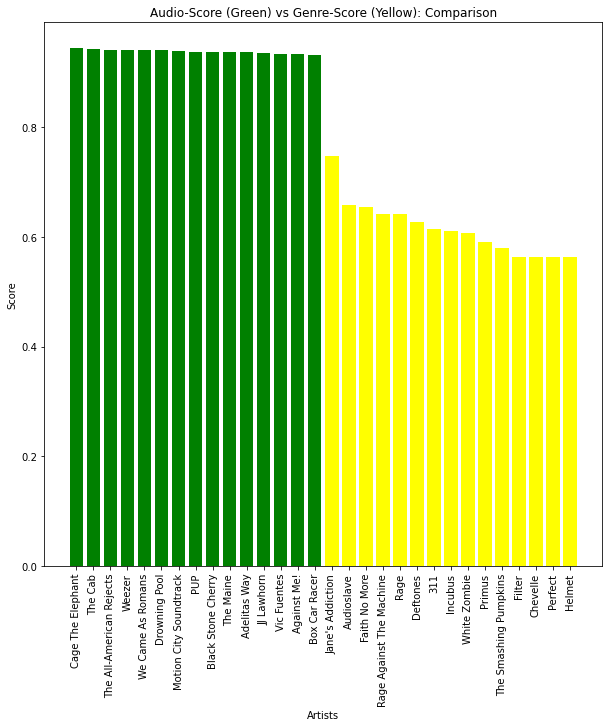

In [5]:
df_affinity = pretty_recommend_artist(df_by_artists, name_rate_dict, how_many)

In [6]:
df_affinity

,audio_affinity,artists,index,genre_affinity
0,0.944173,Cage The Elephant,3612,NaN
1,0.941936,The Cab,23554,NaN
2,0.941471,The All-American Rejects,23380,NaN
3,0.941219,Weezer,26320,NaN
4,0.941219,We Came As Romans,26309,NaN
5,0.941180,Drowning Pool,6520,NaN
6,0.939657,Motion City Soundtrack,16879,NaN
7,0.937997,PUP,18291,NaN
8,0.937703,Black Stone Cherry,2777,NaN
9,0.937006,The Maine,24221,NaN
